In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge

sns.set_style('darkgrid')

In [36]:
train_df = pd.read_csv("../data/train.csv", parse_dates=["date"])
original_train_df = train_df.copy()
test_df = pd.read_csv("../data/test.csv", parse_dates=["date"])

# **EDA**

## **Categorical variables**

In [37]:
display(train_df.head())
display(test_df.head())

row_id       date  country       store                           product  \
0       0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2 2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4 2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

row_id       date  country       store                           product
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

**Observations:**
- There are 3 categorical columns that together describe a univariate time series. Country, Store and Product.

Lets see which countries, stores and products we have data for:

In [38]:
def val_count_df(df, column_name, sort_by_column_name=False):
    value_count = df[column_name].value_counts().reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(normalize=True)*100
    value_count = value_count.reset_index()
    if sort_by_column_name:
        value_count = value_count.sort_values(column_name)
    return value_count



def plot_and_display_valuecounts(df, column_name, sort_by_column_name=False):
    val_count = val_count_df(df, column_name, sort_by_column_name)
    #display(val_count)
    val_count.set_index(column_name).plot.pie(y="Value Count", figsize=(5,5), legend=False, ylabel="");

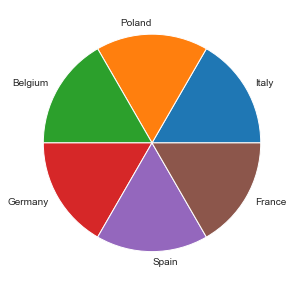

In [39]:
plot_and_display_valuecounts(train_df, "country")

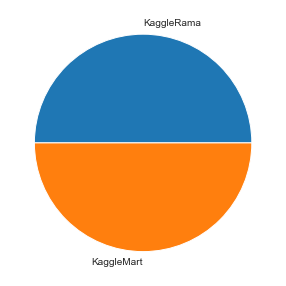

In [40]:
plot_and_display_valuecounts(train_df, "store")

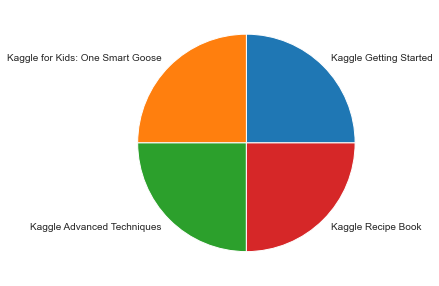

In [41]:
plot_and_display_valuecounts(train_df, "product")

Every group seems to occur in equal amounts, but lets double check to see if every country contains every store, and if every store sells each product:

In [42]:
train_df.groupby(["country","store","product"])["num_sold"].count()

country  store       product                         
Belgium  KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
France   KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                

Yes, every country contains every store and every store contains every product. This gives us **48 univariate time series** all of **length 1461**

## **Time series**

In [43]:
print("Train - Earliest date:", train_df["date"].min())
print("Train - Latest date:", train_df["date"].max())

print("Test - Earliest date:", test_df["date"].min())
print("Test - Latest date:", test_df["date"].max())

Train - Earliest date: 2017-01-01 00:00:00
Train - Latest date: 2020-12-31 00:00:00
Test - Earliest date: 2021-01-01 00:00:00
Test - Latest date: 2021-12-31 00:00:00


- We have **4 years** of data **from 2017-01-01 to 2020-12-31** to train occuring at **daily frequency**.
- We are required to forecast 1 year of data, **from 2021-01-01 to 2021-12-31**

In [44]:
weekly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

In [45]:
def plot_all(df):
    f,axes = plt.subplots(2,2,figsize=(20,15), sharex = True, sharey=True)
    f.tight_layout()
    for n,prod in enumerate(df["product"].unique()):
        plot_df = df.loc[df["product"] == prod]
        sns.lineplot(data=plot_df, x="date", y="num_sold", hue="country", style="store",ax=axes[n//2,n%2])
        axes[n//2,n%2].set_title("Product: "+str(prod))

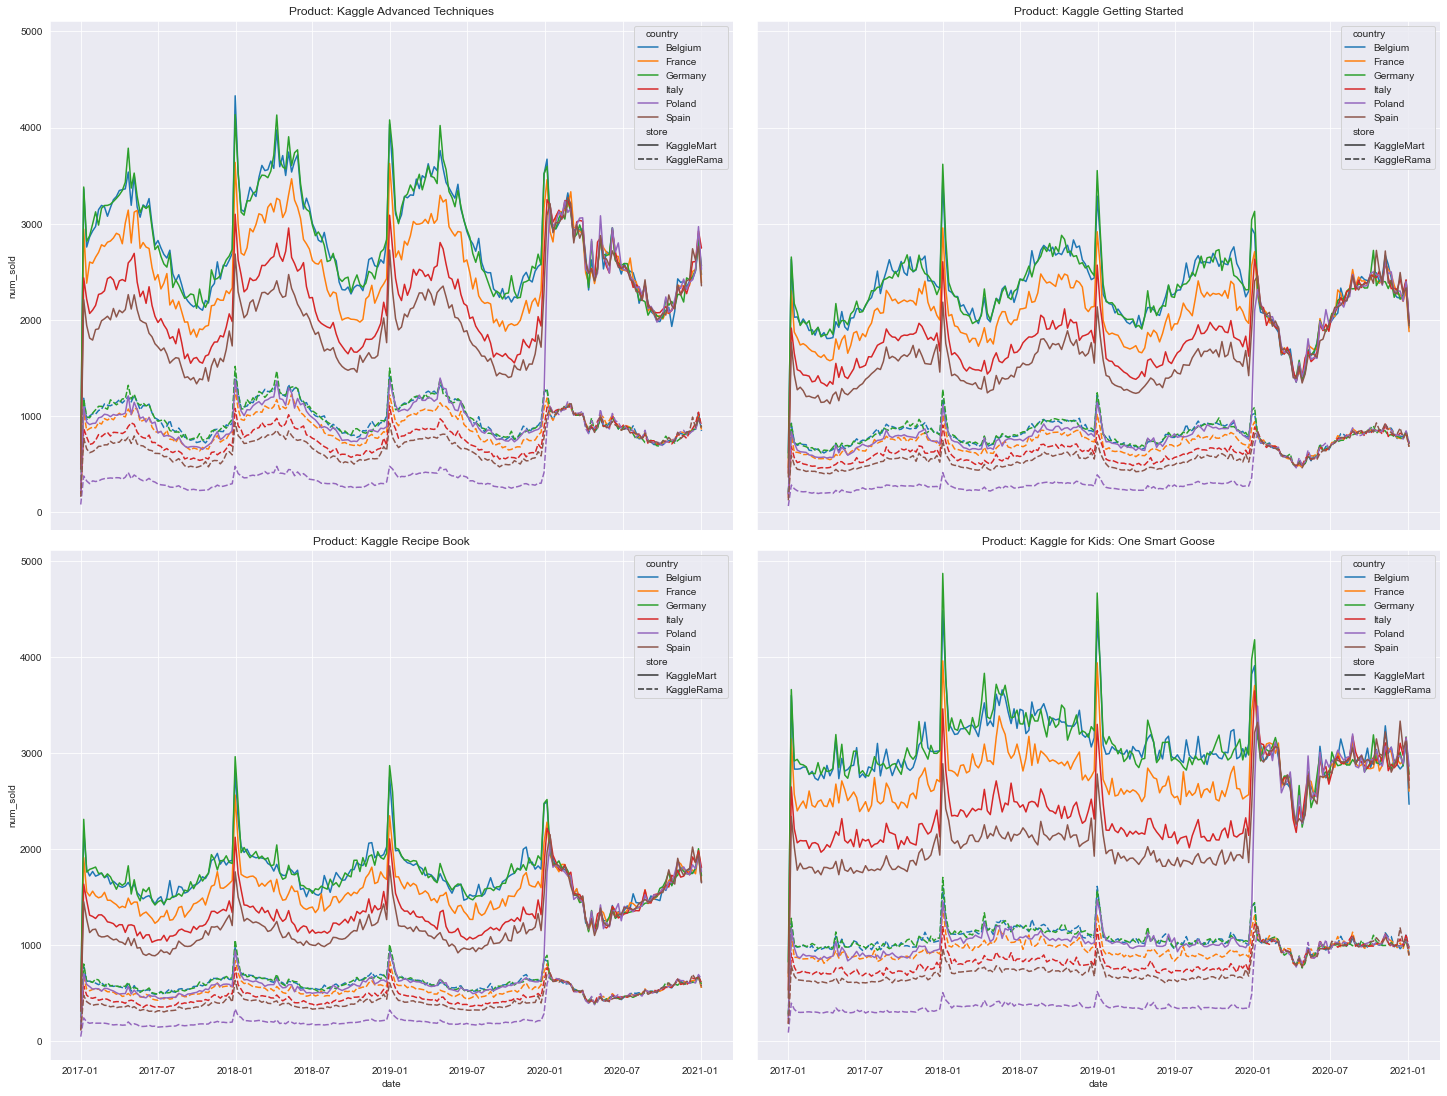

In [46]:
plot_all(weekly_df)

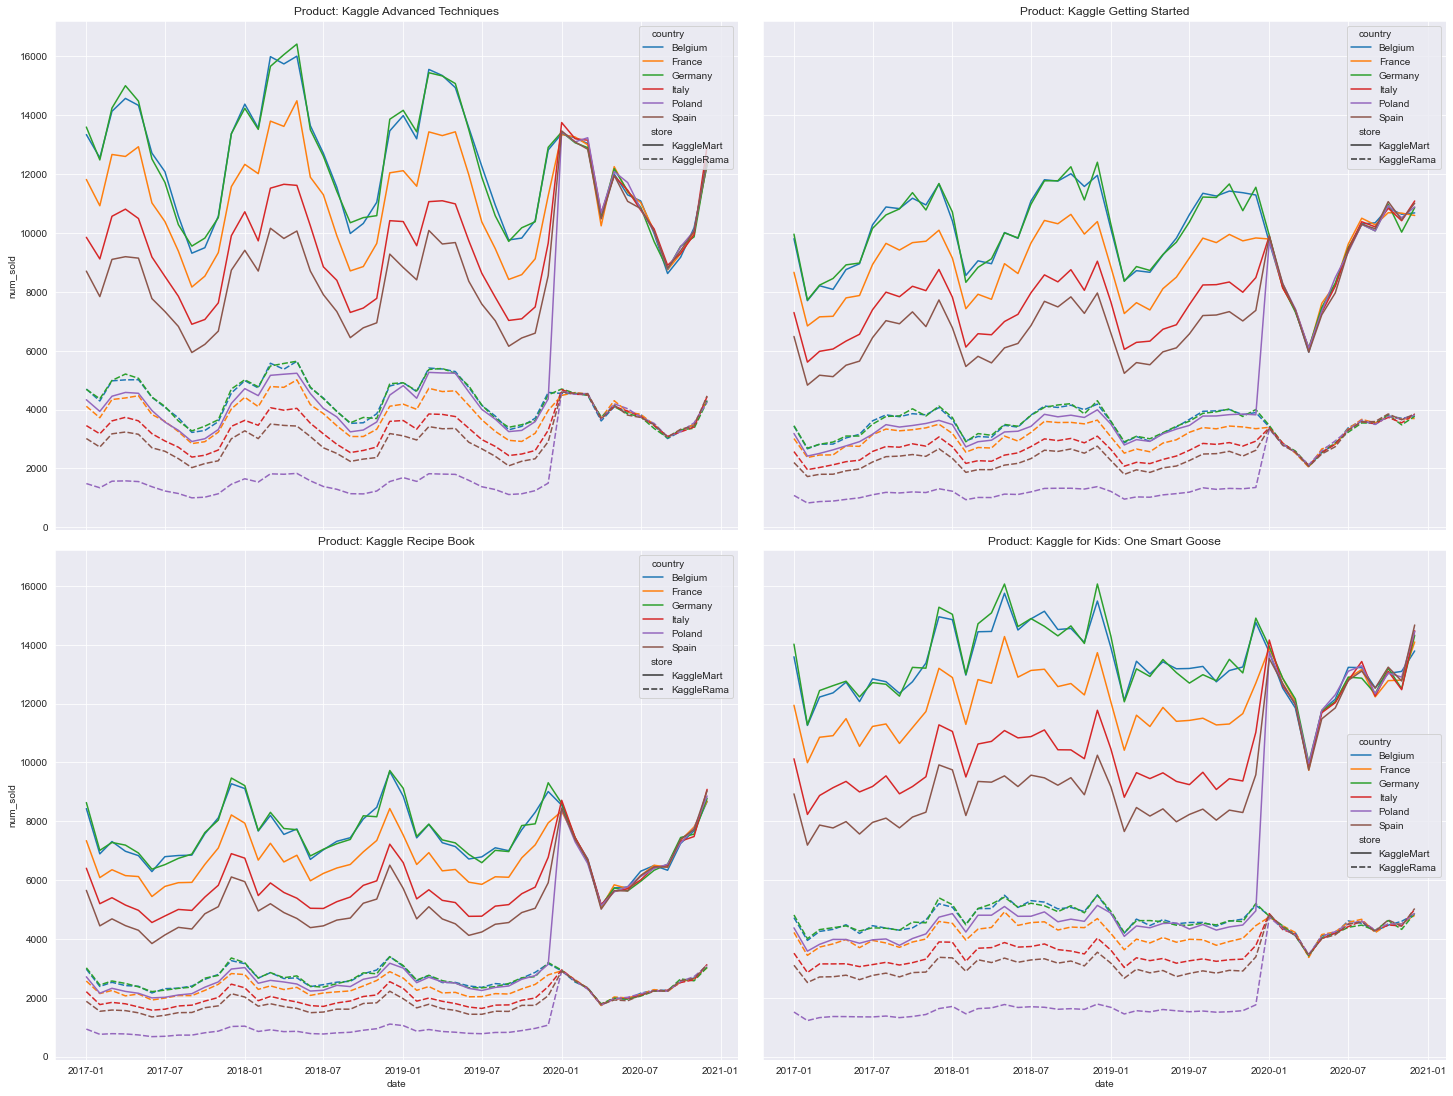

In [47]:
plot_all(monthly_df)

**Observations:**

- The year 2020 is significantly different to other years, with sales being almost identical between countries.
- Each product has a different pattern in number of sales.
- It looks a lot like the pattern in sales between stores is identical. With KaggleMart and KaggleRama following the same pattern but with KaggleRama having less sales.
- Similarly it looks like the pattern in sales between all countries is identical, just with the magnitude of sales being different.

# **Aggregating Time Series**

First we need to show that its a good idea to aggregate the time series across each of the three categorical variables: Store, Country and Product.

### **Store**

Lets test to see if the pattern between stores is the same, regardless of product or country.

In [48]:
store_weights = train_df.groupby("store")["num_sold"].sum()/train_df["num_sold"].sum()
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

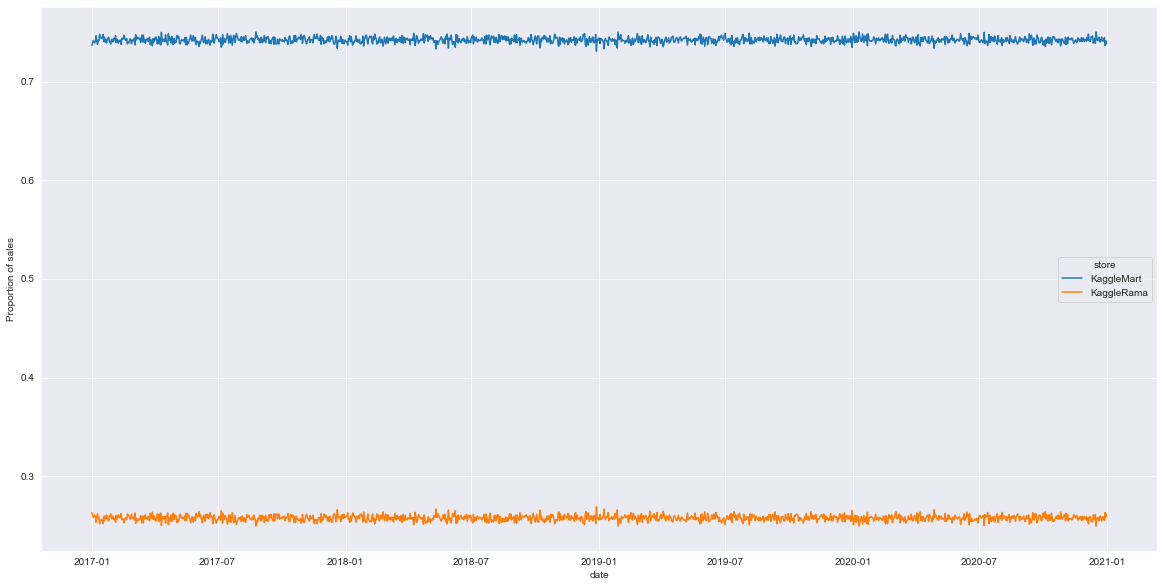

In [49]:
store_ratio_over_time = (train_df.groupby(["date","store"])["num_sold"].sum() / train_df.groupby(["date"])["num_sold"].sum()).reset_index()
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = store_ratio_over_time, x="date", y="num_sold", hue="store");
ax.set_ylabel("Proportion of sales");

KaggleMart appears to consistantly have ~74.25% of the total number of sales. Lets multiply all sales in KaggleRama by a constant so they are comparable to sales in KaggleMart. If the lines between stores overlap perfectly then trend and seasonality are not unique to the store and we can ignore its effect.

In [50]:
def plot_adjusted_store(df):
    new_df = df.copy()
    weights = store_weights.loc["KaggleMart"] / store_weights
    for store in weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * weights[store]
    plot_all(new_df)

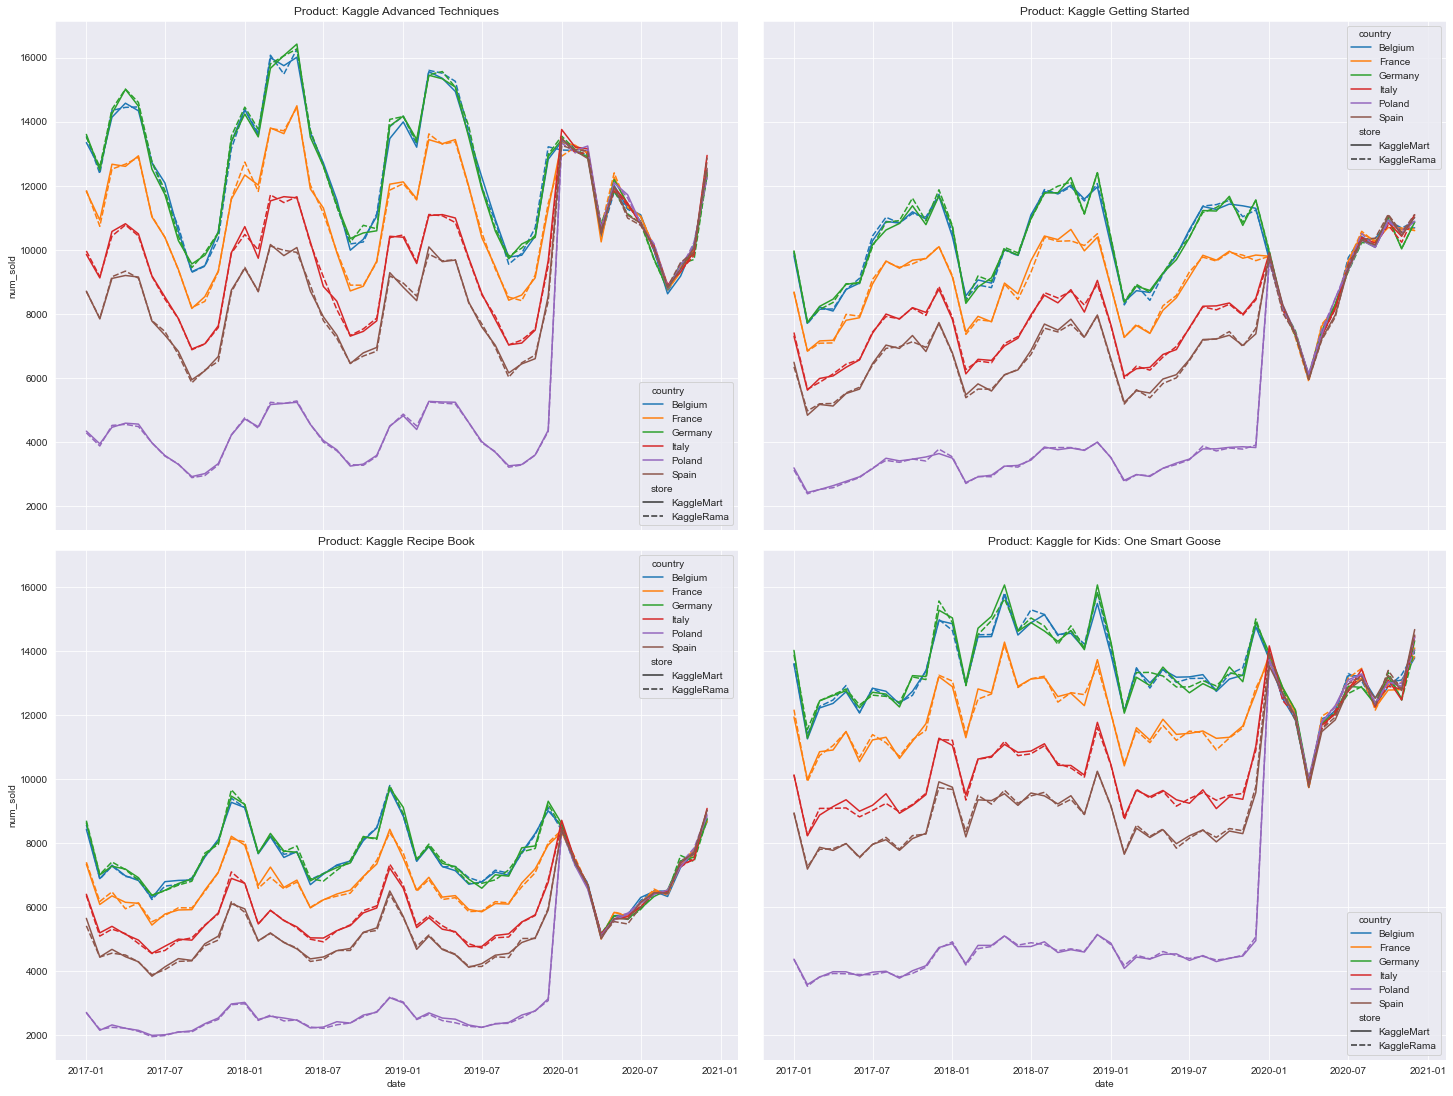

In [51]:
plot_adjusted_store(monthly_df)
#plot_adjusted_store(weekly_df)

**Observations:**
- The dashed and solid lines representing the different stores overlap almost perefectly for all dates.

**Insight:**

- Don't pay attention to the values on the y axis, it doesn't mean anything. The purpose of the graph is only to see if the lines overlap.
- Trend and seasonality are not unique to the store and we can ignore its effect. All differences in sales can be explained by a single constant regardless of time.
- This means we can forecast the store aggregated timeseries, and then disaggregating the forecasts based on historical proportions

### **Countries**

Lets see if the difference in countries, **prior to 2020**, can also be explained by a single constant

In [52]:
country_weights = train_df.loc[train_df["date"] < "2020-01-01"].groupby("country")["num_sold"].sum()/train_df.loc[train_df["date"] < "2020-01-01", "num_sold"].sum()
country_weights

country
Belgium    0.218930
France     0.191360
Germany    0.219586
Italy      0.159383
Poland     0.071348
Spain      0.139393
Name: num_sold, dtype: float64

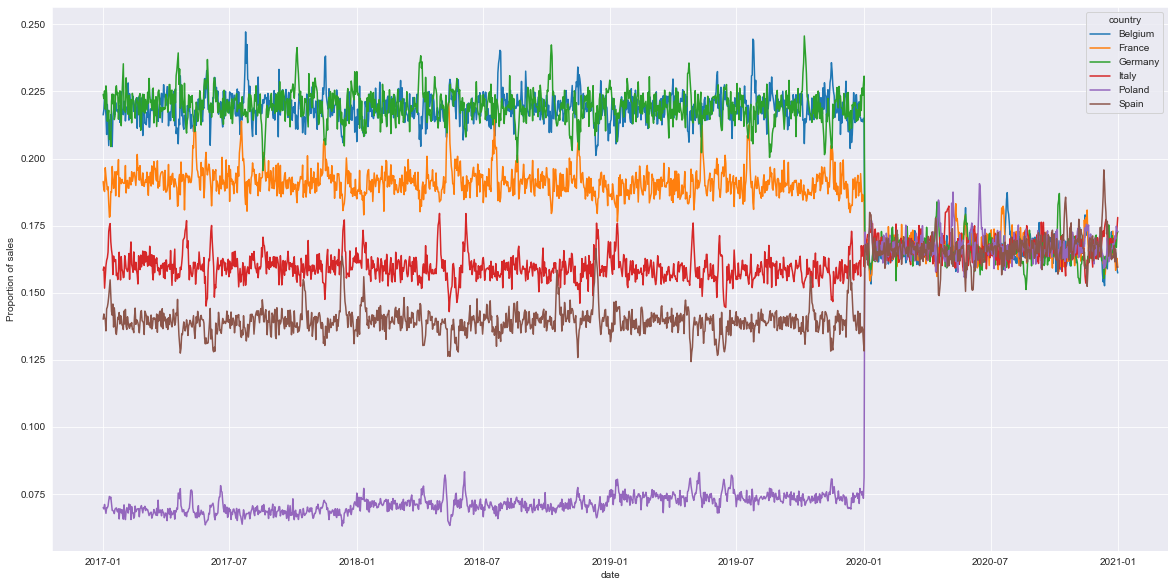

In [53]:
country_ratio_over_time = (train_df.groupby(["date","country"])["num_sold"].sum() / train_df.groupby(["date"])["num_sold"].sum()).reset_index()
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = country_ratio_over_time, x="date", y="num_sold", hue="country");
ax.set_ylabel("Proportion of sales");

Lets multiply all countries by a constant so they are comparable with Belgium.

In [54]:
def plot_adjust_country(df):
    new_df = df.copy()
    
    weights = country_weights.loc["Belgium"] / country_weights
    
    for country in weights.index:
        new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] = new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] *  weights[country]
    #plot_country_product(new_df)
    plot_all(new_df)

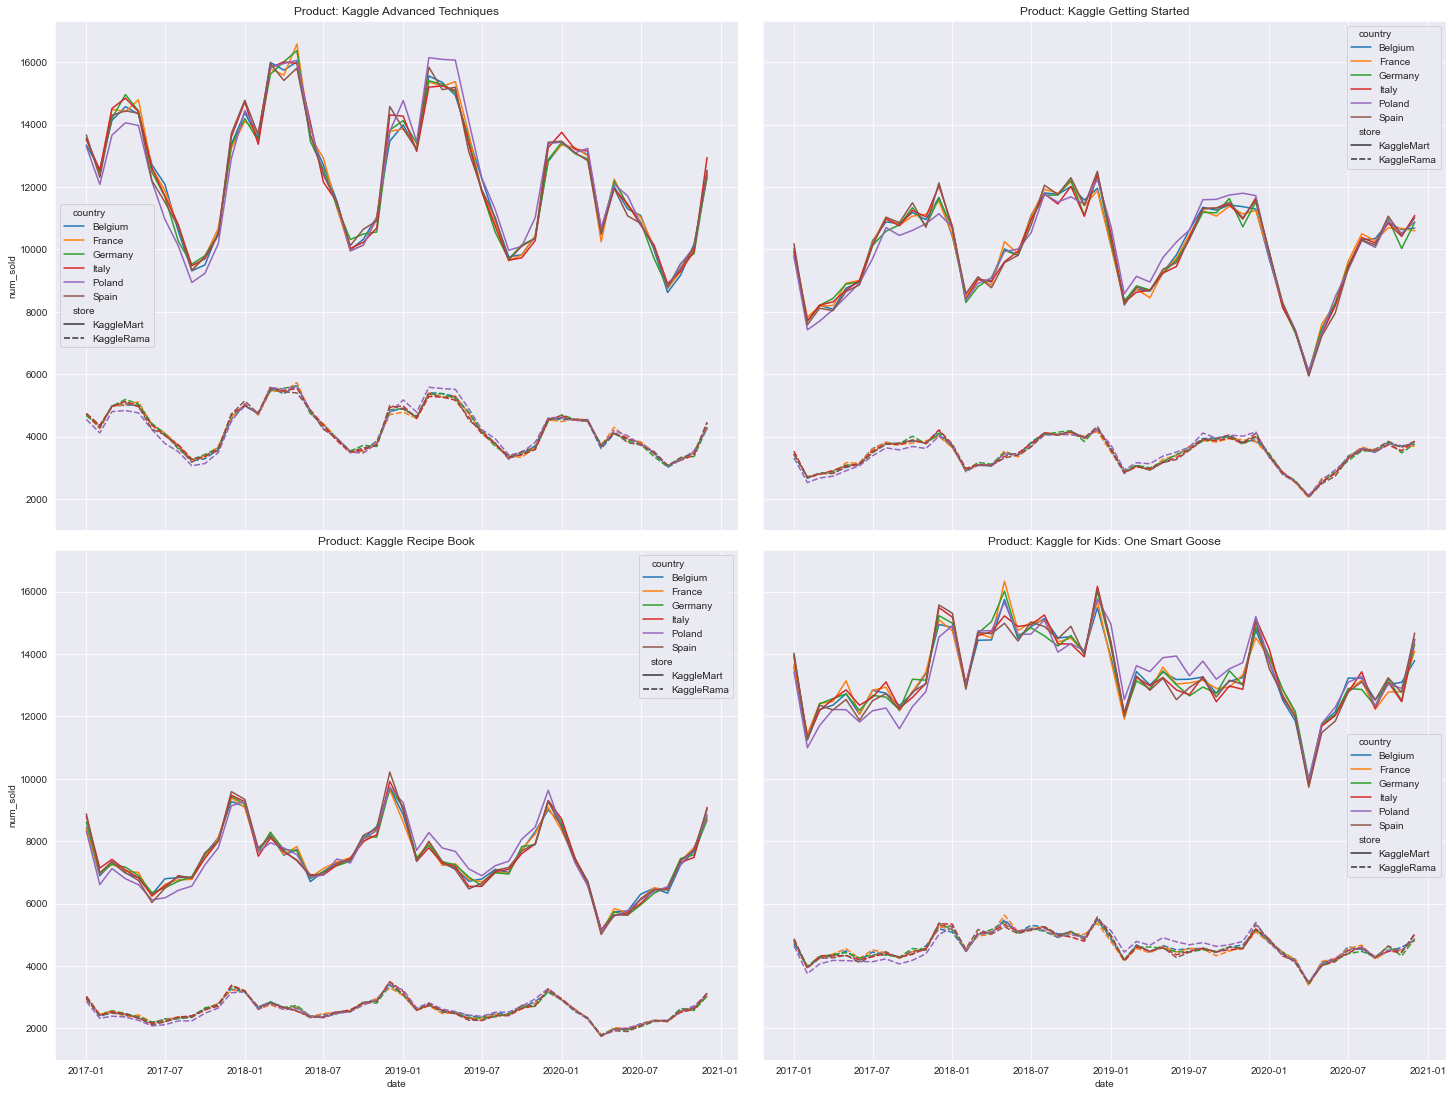

In [55]:
plot_adjust_country(monthly_df)

**Observations:**

- It doesn't seem too bad, although Poland seems a little off
- This means we can forecast the country aggregated series, and then disaggregating the forecasts based on historical proportions
- As countries in 2020 behave differently we can dissagregate based on 2020 proportions (i.e. equally).

### **Country and Store**

Lets try doing this to both country and store at the same time.

In the plots we're effectively making all time series inline with the Belgium KaggleMart store by multiplying by a constant.

In [56]:
def plot_adjust_country_store(df):
    new_df = df.copy()
    
    store_weights_ = store_weights.loc["KaggleMart"] / store_weights
    country_weights_ = country_weights.loc["Belgium"] / country_weights
    
    for country in country_weights_.index:
        new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] = new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] *  country_weights_[country]
    for store in store_weights_.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * store_weights_[store]
    #plot_country_product(new_df)
    plot_all(new_df)

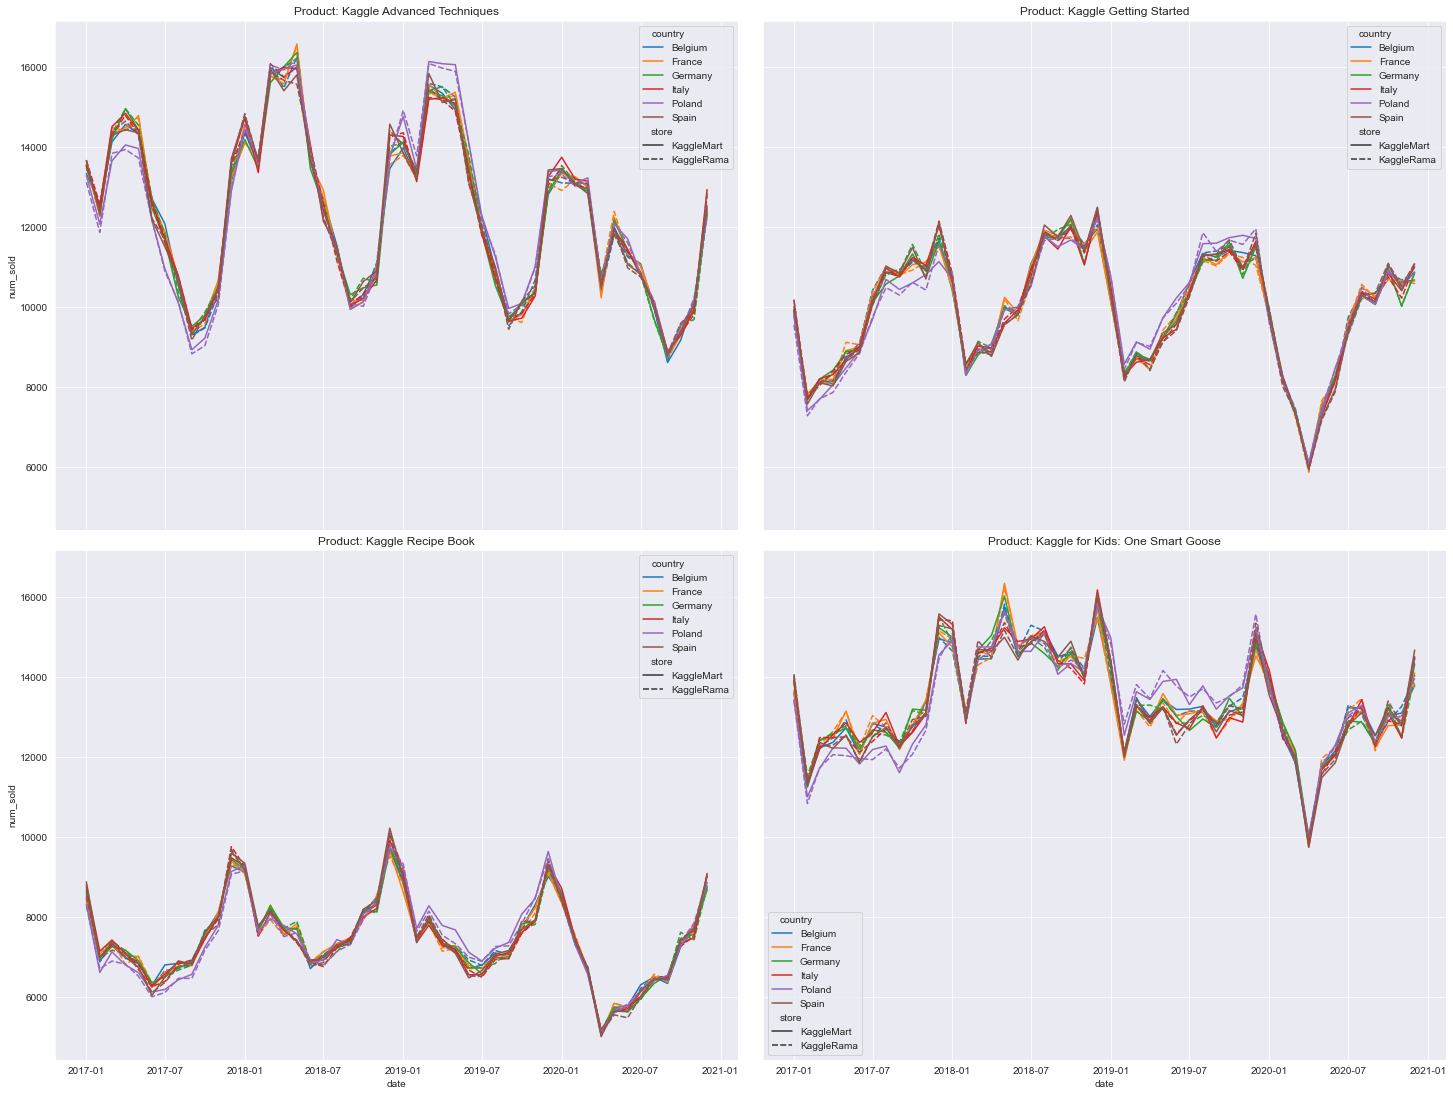

In [57]:
plot_adjust_country_store(monthly_df)
#plot_adjust_country_store(weekly_df)

**Observations**

It's not 100% perfect, particularly for Poland, but it seems pretty good.

**Insights**

We should be able to aggregate store together to make the forecast, and then disaggregate using the ratios of historical net sales between stores to get the actual forecast for each store. Country is a little different as from 2020 onwards all countries are the same, so we can can give all countries an equal proportion of sales, or we can assume 2020 was an exception (probably a poor assumption) and use the countries ratios calculated before 2020 to divide the forecast.

### **Product**

Product requires a different approach

In [58]:
product_df = train_df.groupby(["date","product"])["num_sold"].sum().reset_index()

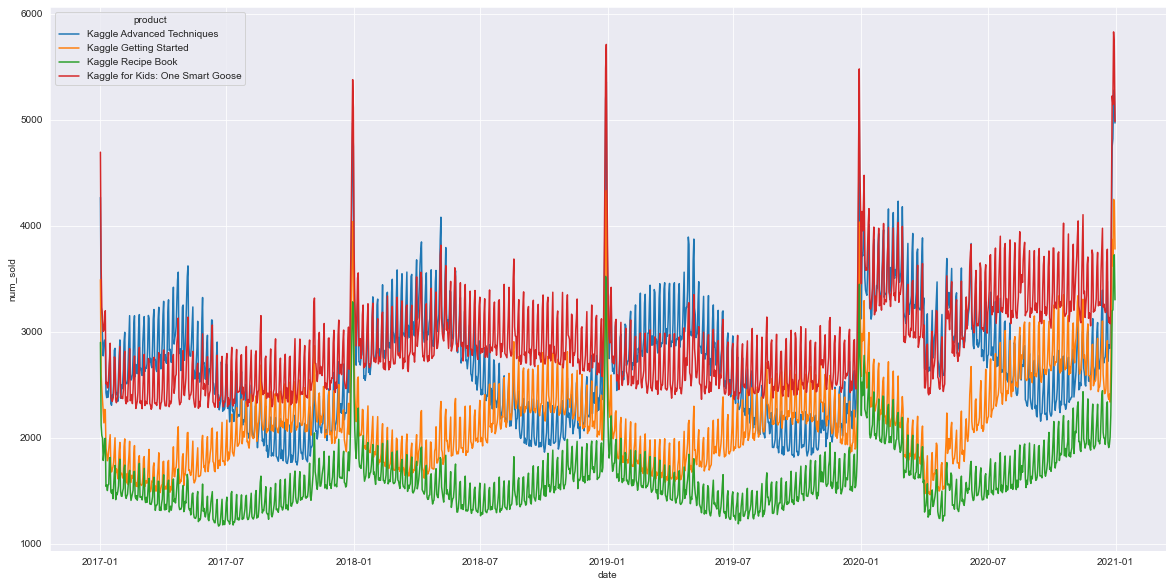

In [59]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_df, x="date", y="num_sold", hue="product");

**Product ratio for each date**

In [60]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df.head(4)

date                           product    ratios
0 2017-01-01        Kaggle Advanced Techniques  0.277944
1 2017-01-01            Kaggle Getting Started  0.227462
2 2017-01-01                Kaggle Recipe Book  0.188900
3 2017-01-01  Kaggle for Kids: One Smart Goose  0.305693

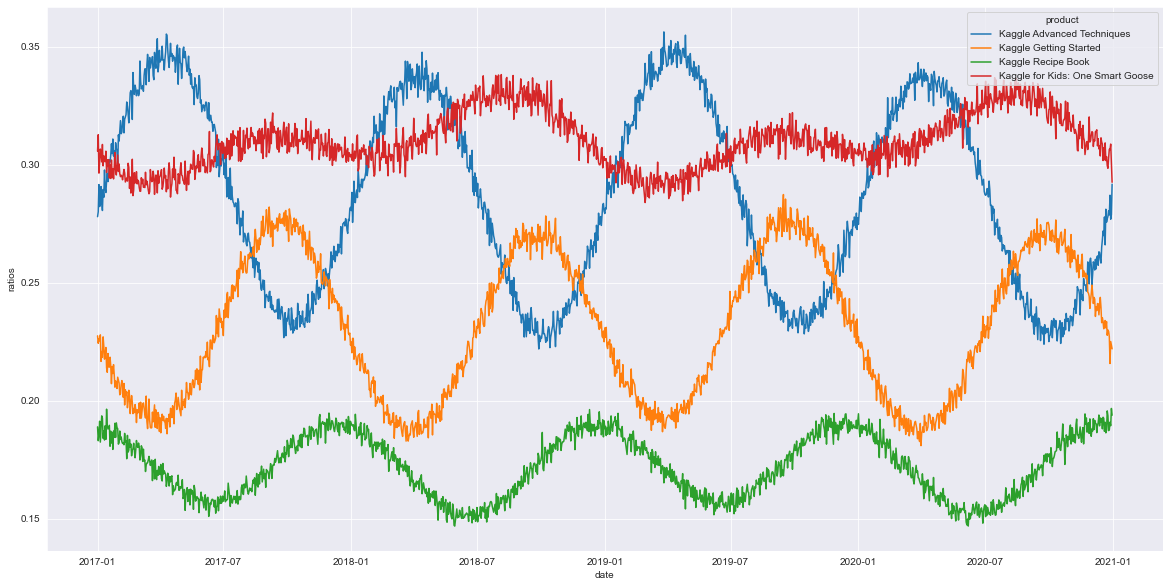

In [61]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="ratios", hue="product");

**Observations**

The product ratio shows clear sinsidual lines for each product, with a period of 2 years.

**Insight**

As we have a clear seasonal pattern of the ratio of sales for each product, we do not need to forecast each product individually (or treat product as a categorical variable etc.). Instead we can forecast the sum of all sales each day, then afterwards convert the forecasted sum down to the forecast for each product, using the forecasted **ratios** for each date.

**Conclusions** 

All this together means we only need to forecast 2 time series:
1. The total sales each day
2. The ratio in number of sales for each product each day

Once we have completed the forecasts we can break the forecast down into the 3 categorical variables: Product, Country and Store.

## **Aggregated Time Series**

Lets take a look at the aggregated time series.

In [62]:
train_df = train_df.groupby(["date"])["num_sold"].sum().reset_index()

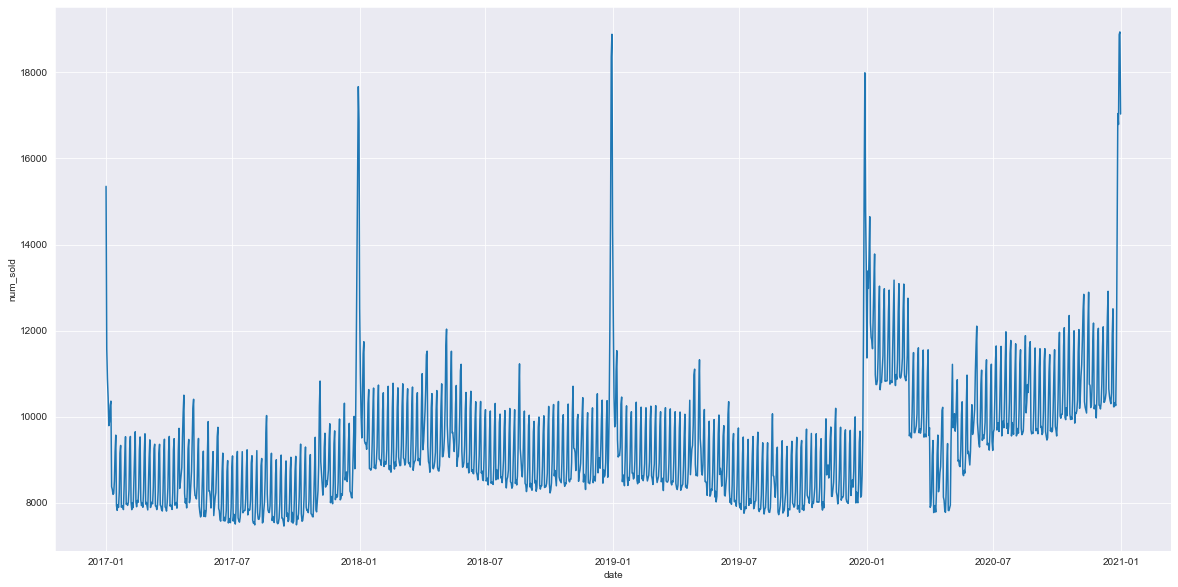

In [63]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_df, x="date", y="num_sold");

This is the time series we need to forecast, the unusual nature of 2020 makes this forecast difficult.

In [64]:
weekly_df = train_df.groupby([pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby([pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

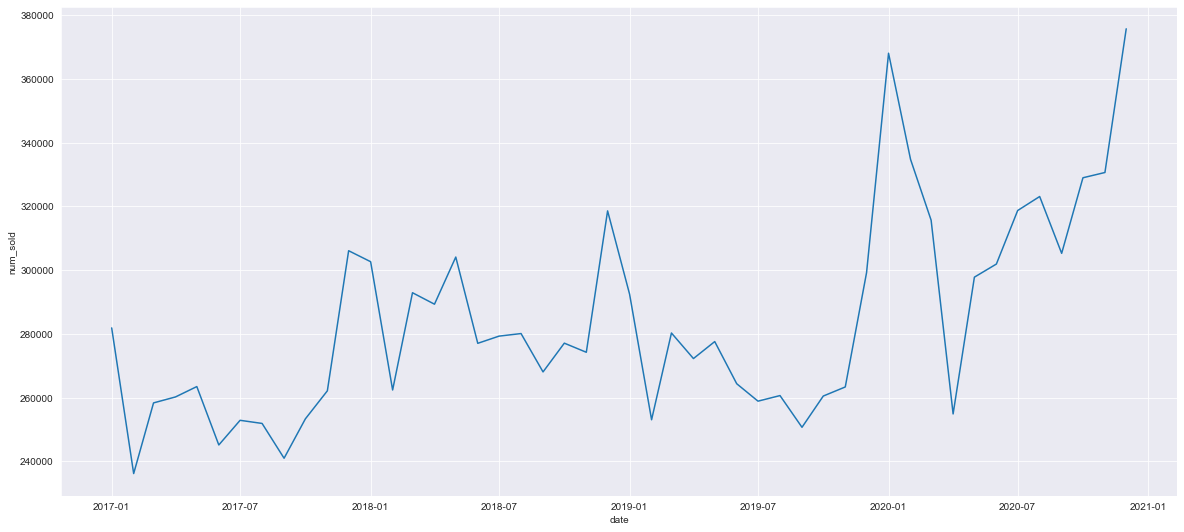

In [65]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=monthly_df, x="date", y="num_sold");

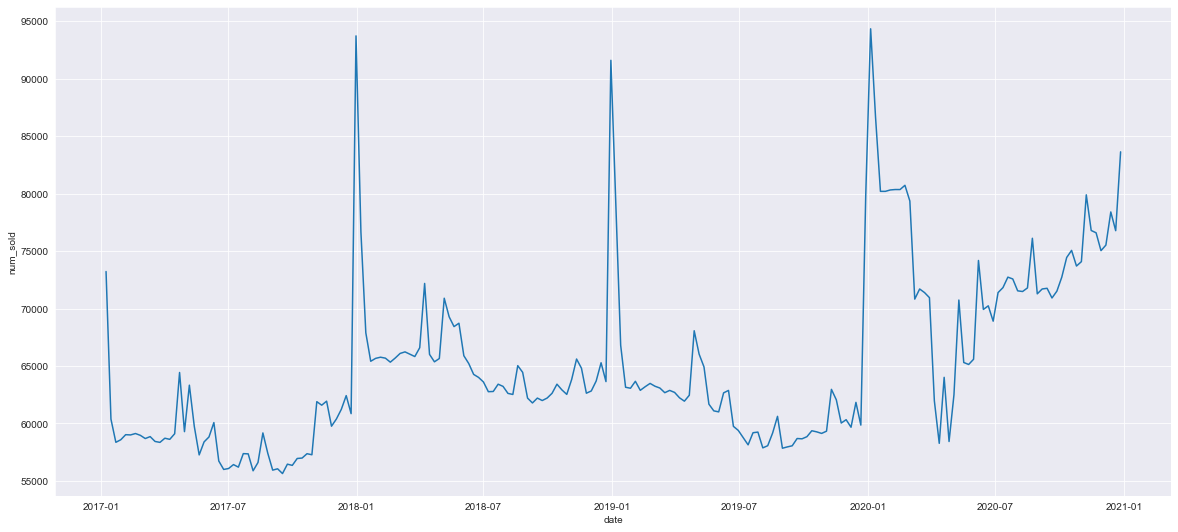

In [66]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=weekly_df[1:-1], x="date", y="num_sold");

## **Seasonality**

In [67]:
def plot_seasonality(df, x_axis):
    
    #remove the leap year date
    df = df.loc[df["date"] != "2020-02-29"].copy()

    df["month"] = df["date"].dt.month
    df["day_of_week"] = df["date"].dt.dayofweek
    df["day_of_year"] = df["date"].dt.dayofyear
    #account for leap year
    df["day_of_year"] = df.apply(lambda x: x["day_of_year"]-1 if x["date"] > pd.Timestamp("2020-02-29") else x["day_of_year"], axis=1)
        
    df_no_2020 = df.loc[df["date"] < "2020-01-01"]

    f,axes = plt.subplots(2,1,figsize=(20,16))
    sns.lineplot(data=df, x=x_axis, y="num_sold", ax=axes[0]);
    sns.lineplot(data=df_no_2020, x=x_axis, y="num_sold", ax=axes[1]);
    axes[0].set_title("{} Seasonality - all years".format(x_axis))
    axes[1].set_title("{} Seasonality - not including 2020".format(x_axis))

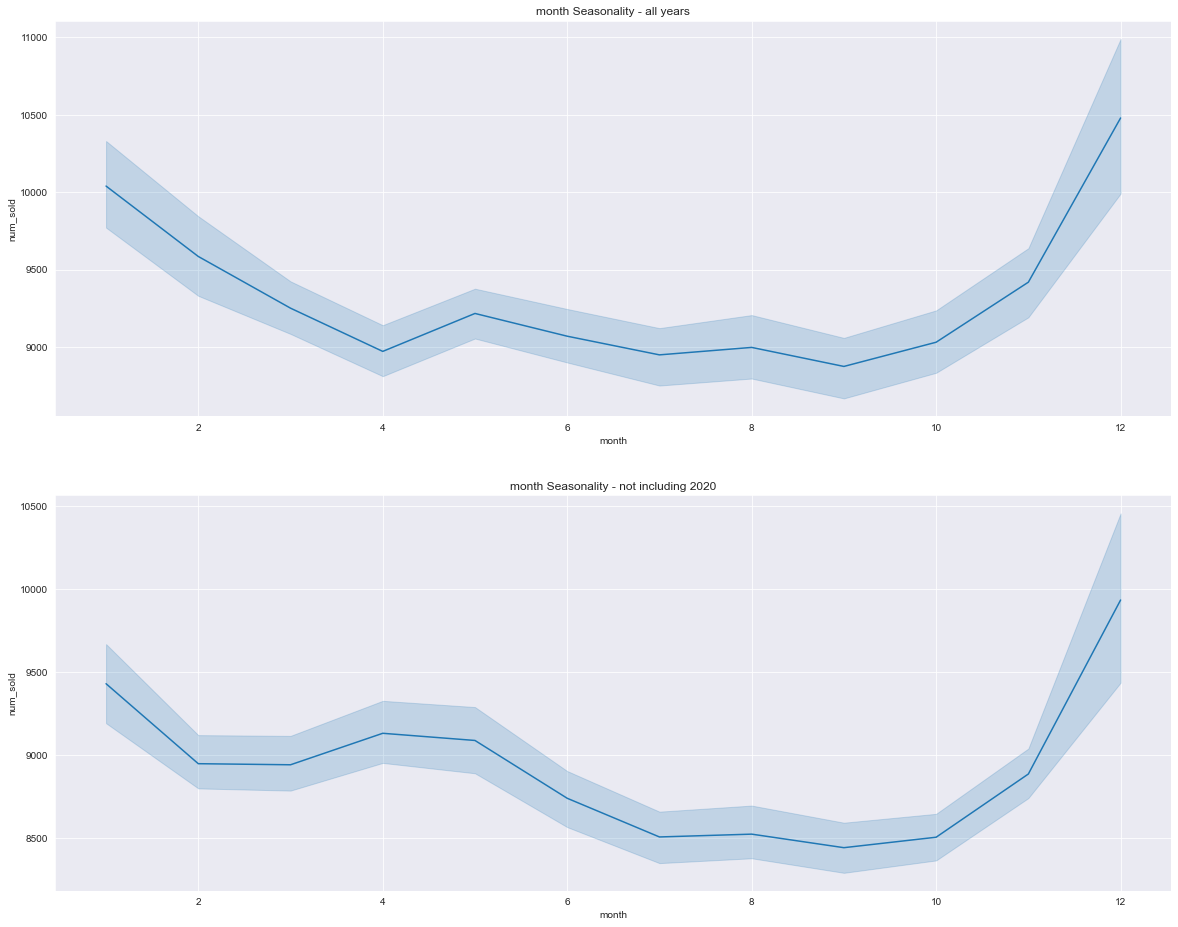

In [68]:
plot_seasonality(train_df, "month")

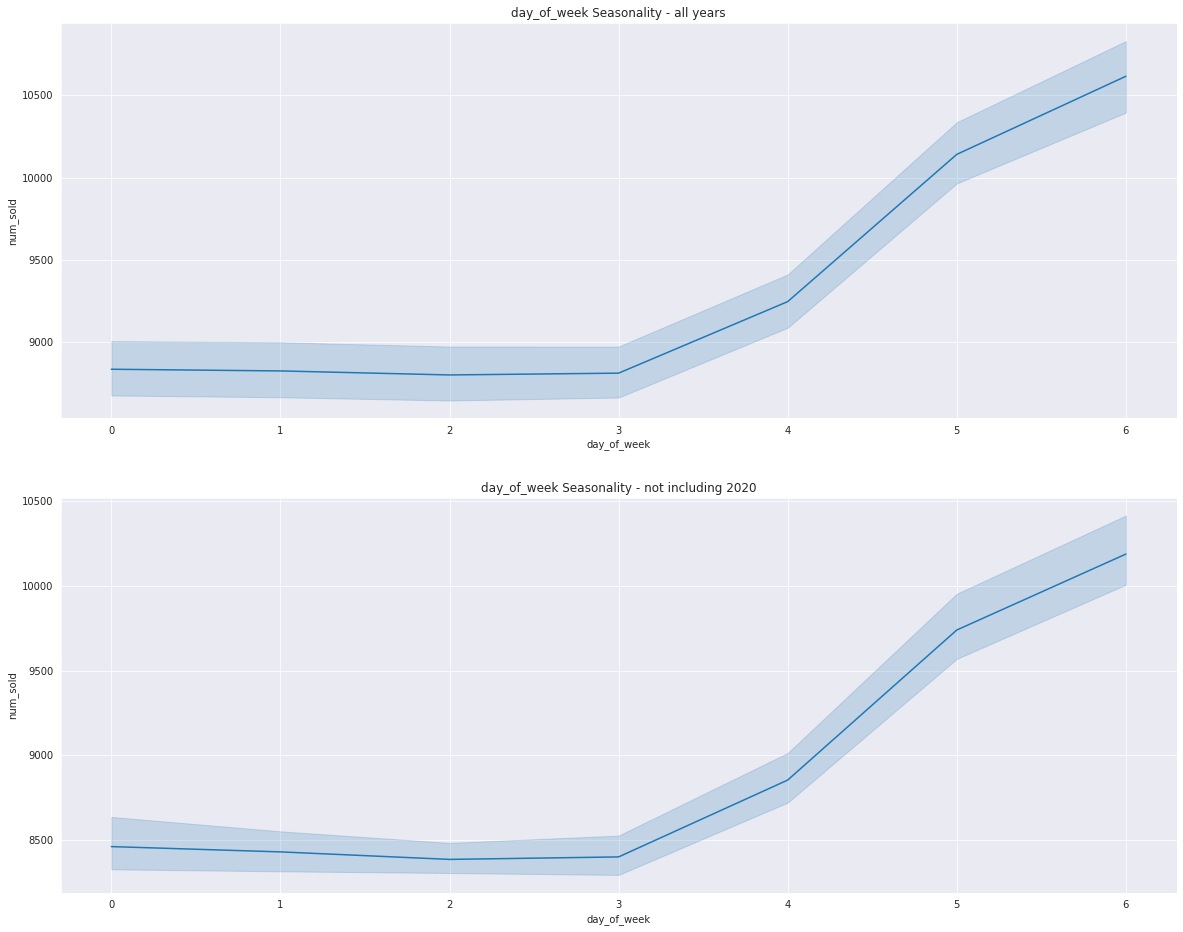

In [35]:
plot_seasonality(train_df, "day_of_week")

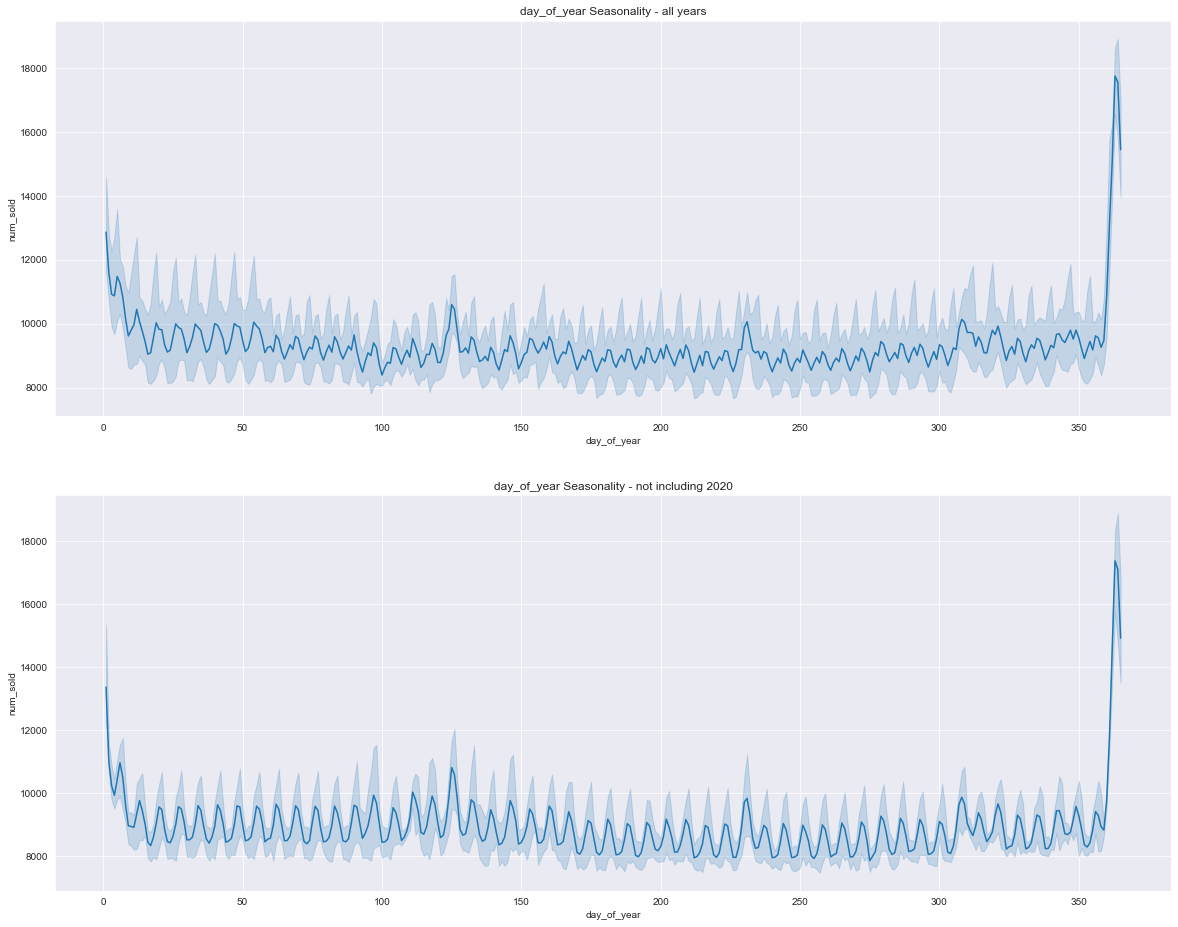

In [34]:
plot_seasonality(train_df, "day_of_year")

# **Modeling**

We required 2 forecasts:

1. **Total Sales** Forecast
2. **Product Sales Ratio** Forecast

## **Total Sales Forecast**

Lets revist the graph of sales we wish to forecast:

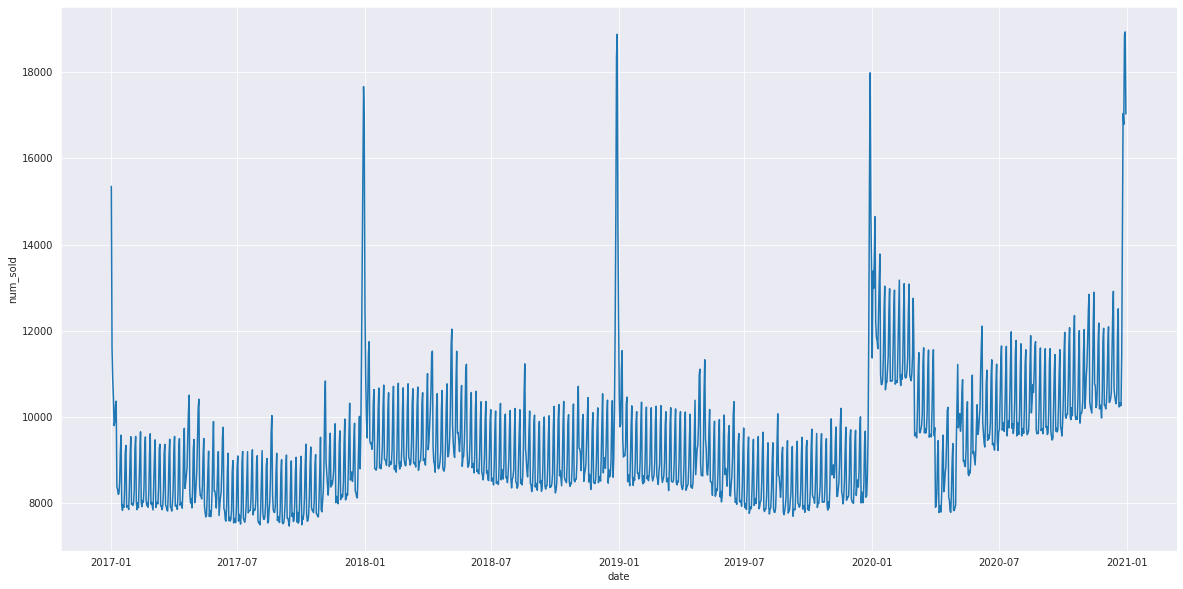

In [37]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_df, x="date", y="num_sold");

There are atleast two important things to consider about 2020:
1. The number of sales from all countries becomes equal; massively increaseing the total number of products sold.
2. The impact of Covid, particuraly from around the dates March-May.

I am going to assume the first effect does not change in 2021. The second effect will change, to deal with this I'm going to completely exclude these months from the forecast.

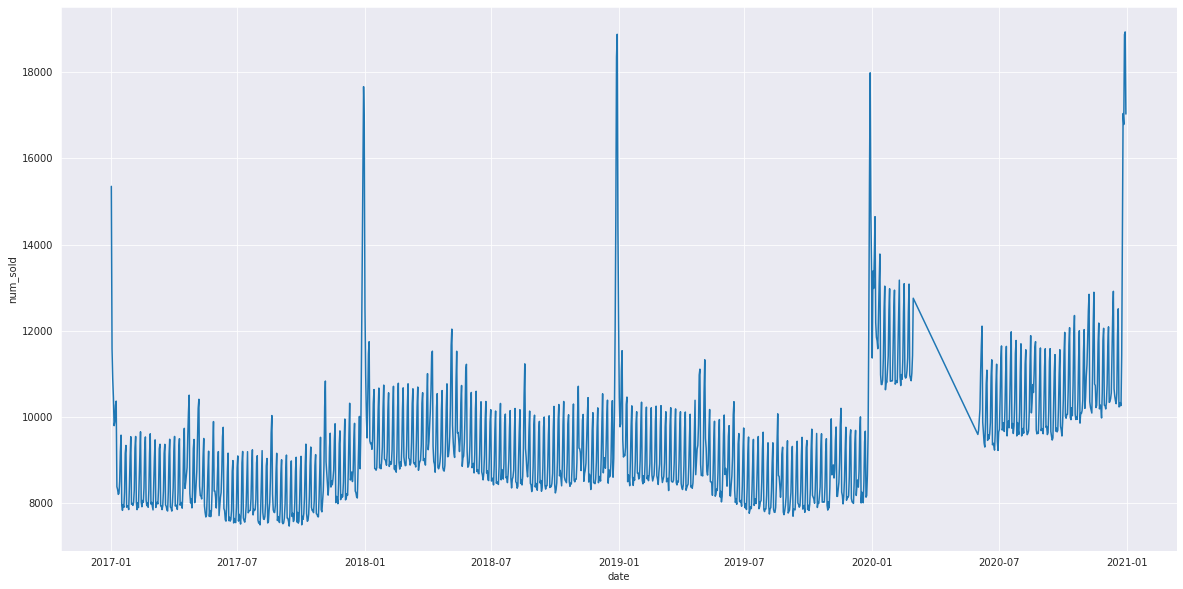

In [38]:
train_nocovid_df = train_df.loc[~((train_df["date"] >= "2020-03-01") & (train_df["date"] < "2020-06-01"))]
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_nocovid_df, x="date", y="num_sold");

In [39]:
#get the dates to forecast for
test_total_sales_df = test_df.groupby(["date"])["row_id"].first().reset_index().drop(columns="row_id")
#keep dates for later
test_total_sales_dates = test_total_sales_df[["date"]]

In [40]:
def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    #account for leap year
    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    
    new_df["year"] = df["date"].dt.year
    new_df = new_df.drop(columns=["date","month","day_of_year"])
    
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df
    

In [41]:
train_total_sales_df = feature_engineer(train_nocovid_df)
test_total_sales_df = feature_engineer(test_total_sales_df)

In [42]:
display(train_total_sales_df.head(2))
display(test_total_sales_df.head(2))

num_sold  month_sin  month_cos  year  important_dates_1  important_dates_2  \
0     15352        0.5   0.866025  2017                  1                  0   
1     11578        0.5   0.866025  2017                  0                  1   

   important_dates_3  important_dates_4  important_dates_5  important_dates_6  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   

   ...  important_dates_126  important_dates_360  important_dates_361  \
0  ...                    0                    0                    0   
1  ...                    0                    0                    0   

   important_dates_362  important_dates_363  important_dates_364  \
0                    0                    0                    0   
1                    0                    0                    0   

   important_dates_365  day_of_week_1  day_of_week_2  day_of_week_3  
0                    0              0              0              1  
1                    0              0              0              0  

[2 rows x 23 columns]

month_sin  month_cos  year  important_dates_1  important_dates_2  \
0        0.5   0.866025  2021                  1                  0   
1        0.5   0.866025  2021                  0                  1   

   important_dates_3  important_dates_4  important_dates_5  important_dates_6  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   

   important_dates_7  ...  important_dates_126  important_dates_360  \
0                  0  ...                    0                    0   
1                  0  ...                    0                    0   

   important_dates_361  important_dates_362  important_dates_363  \
0                    0                    0                    0   
1                    0                    0                    0   

   important_dates_364  important_dates_365  day_of_week_1  day_of_week_2  \
0                    0                    0              1              0   
1                    0                    0              0              1   

   day_of_week_3  
0              0  
1              0  

[2 rows x 22 columns]

In [43]:
y = train_total_sales_df["num_sold"]
X = train_total_sales_df.drop(columns="num_sold")
X_test = test_total_sales_df

Define and fit the model, then make the forecast.

In [44]:
model = Ridge(tol=1e-2, max_iter=1000000, random_state=0)
model.fit(X, y)
preds = model.predict(X_test)
test_total_sales_dates["num_sold"] = preds

Visualising the forecast:

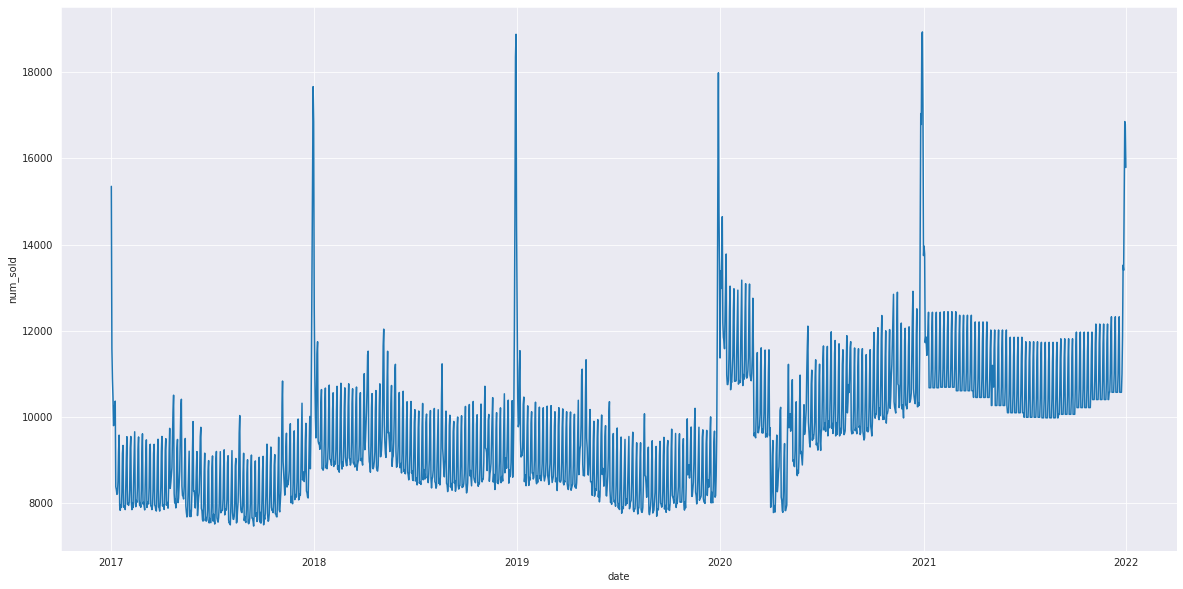

In [45]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = pd.concat([train_df,test_total_sales_dates]).reset_index(drop=True), x="date", y="num_sold");

The forecast looks okay, but theres room for improvement.

## **Product Ratio Forecast**

We now need to forecast the sales ratio between products for 2021.

The period of the product ratio sinsidual curves appear to be 2 years. So to forecast 2021 I resuse the ratios from 2019. This will carry over some of the noise which perhaps isn't ideal, but it'll work fine for a baseline.

In [46]:
product_ratio_2019 = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2019].copy()
product_ratio_2019["mm-dd"] = product_ratio_2019["date"].dt.strftime('%m-%d')
product_ratio_2019 = product_ratio_2019.drop(columns="date")

test_product_ratio_df = test_df.copy()
test_product_ratio_df["mm-dd"] = test_product_ratio_df["date"].dt.strftime('%m-%d')

test_product_ratio_df = pd.merge(test_product_ratio_df,product_ratio_2019, how="left", on = ["mm-dd","product"])
test_product_ratio_df.head()

row_id       date  country       store                           product  \
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   mm-dd    ratios  
0  01-01  0.279273  
1  01-01  0.230832  
2  01-01  0.188119  
3  01-01  0.301776  
4  01-01  0.279273

Visualising the forecast:

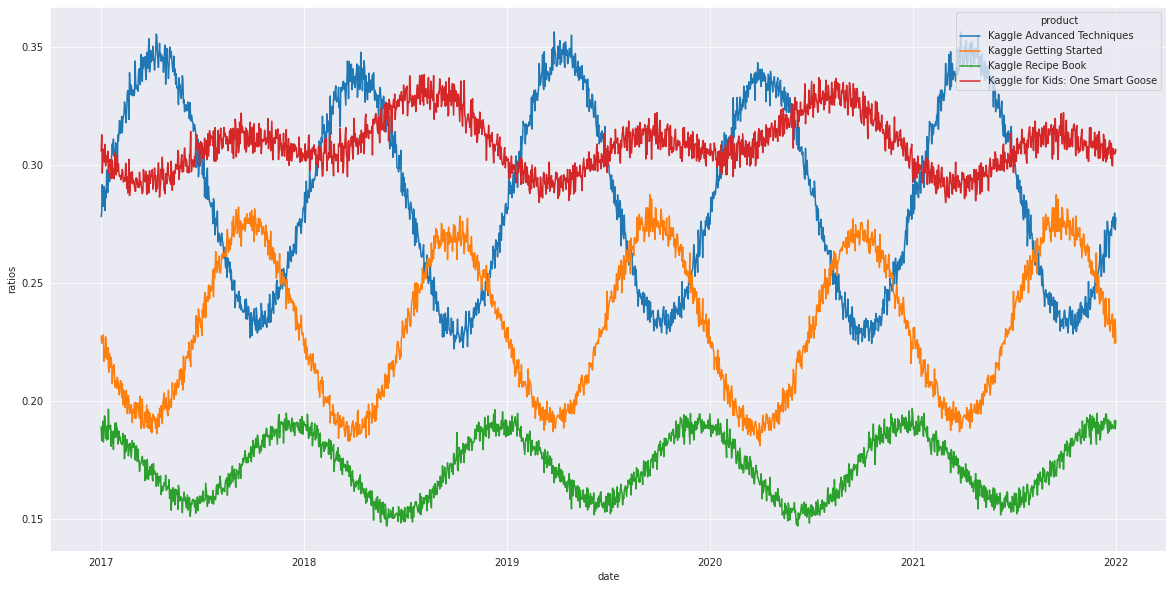

In [47]:
temp_df = pd.concat([product_ratio_df,test_product_ratio_df]).reset_index(drop=True)
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=temp_df, x="date", y="ratios", hue="product");

# **Disaggregating Total Sales Forecast**

Now we have our two required forecasts, we need to divide the total sales forecast between the categorical variables.

In [48]:
test_sub_df = pd.merge(test_df, test_total_sales_dates, how="left")
test_sub_df["ratios"] = test_product_ratio_df["ratios"]
test_sub_df.head()

row_id       date  country       store                           product  \
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

       num_sold    ratios  
0  13744.616925  0.279273  
1  13744.616925  0.230832  
2  13744.616925  0.188119  
3  13744.616925  0.301776  
4  13744.616925  0.279273

In [49]:
def disaggregate_forecast(df):
    new_df = df.copy()
    
    stores_weights = original_train_df.groupby("store")["num_sold"].sum()/original_train_df["num_sold"].sum()
    country_weights = pd.Series(index = test_sub_df["country"].unique(),data = 1/6)

    for country in country_weights.index:
        new_df.loc[(new_df["country"] == country), "num_sold"] = new_df.loc[(new_df["country"] == country), "num_sold"] *  country_weights[country]
        
    for store in store_weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * store_weights[store]
    
    #apply product weights (which is dependent on date)
    new_df["num_sold"] = new_df["num_sold"] * new_df["ratios"]
    new_df["num_sold"] = new_df["num_sold"].round()
    new_df = new_df.drop(columns=["ratios"])
    
    return new_df

In [50]:
final_df = disaggregate_forecast(test_sub_df)
final_df

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  num_sold  
0            Kaggle Advanced Techniques     475.0  
1                Kaggle Getting Started     393.0  
2                    Kaggle Recipe Book     320.0  
3      Kaggle for Kids: One Smart Goose     513.0  
4            Kaggle Advanced Techniques     165.0  
...                                 ...       ...  
17515  Kaggle for Kids: One Smart Goose     599.0  
17516        Kaggle Advanced Techniques     188.0  
17517            Kaggle Getting Started     152.0  
17518                Kaggle Recipe Book     130.0  
17519  Kaggle for Kids: One Smart Goose     208.0  

[17520 rows x 6 columns]

Finally lets visualise the forecasts for all countries, products and stores:

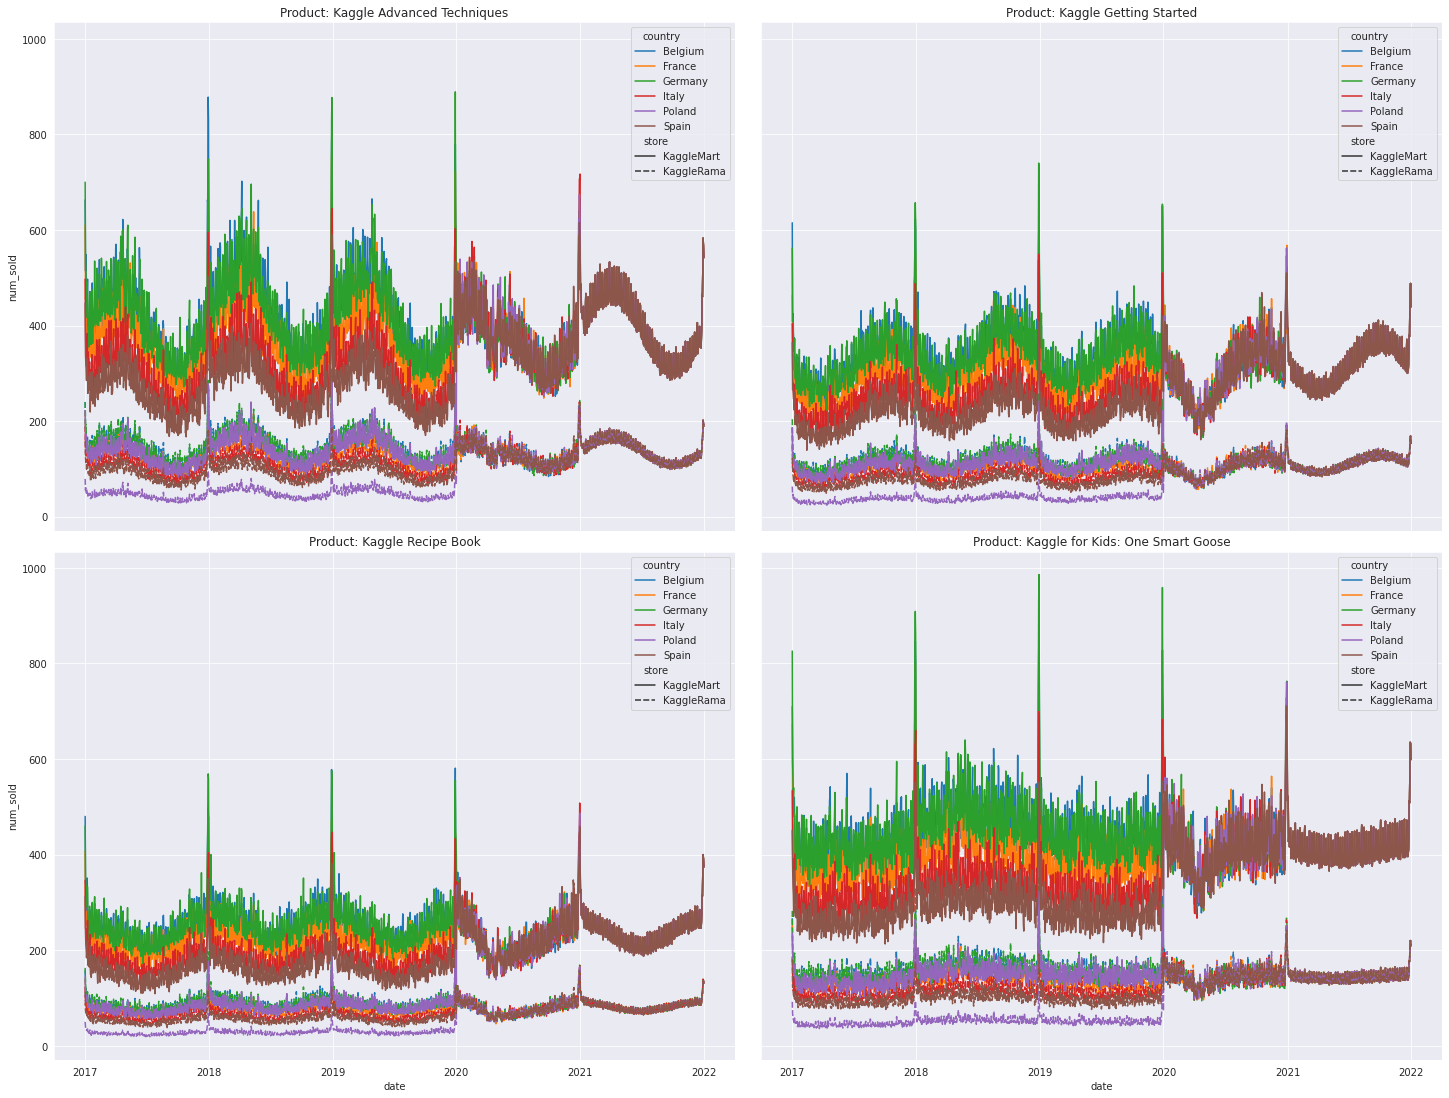

In [51]:
plot_all(pd.concat([original_train_df,final_df]).reset_index(drop=True))

# **Submission**

In [52]:
submission = pd.read_csv("../input/tabular-playground-series-sep-2022/sample_submission.csv")
submission["num_sold"] = final_df["num_sold"]

In [53]:
submission.to_csv('submission.csv', index = False)